In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_docs').getOrCreate()
from pyspark.sql.functions import col, sum,  mean, stddev, regexp_replace, expr, log, when
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType)
from pyspark.ml.feature import VectorAssembler

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/24 08:07:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [22]:
# Import the data
msd = spark.read.csv('Project Data/benefit_type_data_merged_cleaned.csv',inferSchema=True,header=True) 

column_names = msd.columns[:42]
msd = msd.select([col(column) for column in column_names])
msd.show(5)

+------+-----------------+-------+---------+--------+--------+--------+--------+-----------+--------+----------+--------+----------------------------------------+------------------+-------------------+--------+----------+---------+---------+---------+---------+------------+---------+-----------+---------+-----------------------------------------+-------------------+------------------------+--------+----------+---------+---------+---------+---------+------------+---------+-----------+---------+-----------------------------------------+-------------------+-------------------+-----------------------+
|  Date|Jobseeker Support|JS Male|JS Female|JS 18-24|JS 25-39|JS 40-54|JS 55-64|JS European|JS Maori|JS Pacific|JS Asian|JS Middle Eastern/Latin American/African|JS Other ethnicity|Sole Parent Support|SPS Male|SPS Female|SPS 18-24|SPS 25-39|SPS 40-54|SPS 55-64|SPS European|SPS Maori|SPS Pacific|SPS Asian|SPS Middle Eastern/Latin American/African|SPS Other ethnicity|Supported Living Payment|SL

In [23]:
columns_to_convert = msd.columns[1:]  
for column in columns_to_convert:
    msd = msd.withColumn(column, regexp_replace(col(column), ',', '').cast('float'))
msd.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Jobseeker Support: float (nullable = true)
 |-- JS Male: float (nullable = true)
 |-- JS Female: float (nullable = true)
 |-- JS 18-24: float (nullable = true)
 |-- JS 25-39: float (nullable = true)
 |-- JS 40-54: float (nullable = true)
 |-- JS 55-64: float (nullable = true)
 |-- JS European: float (nullable = true)
 |-- JS Maori: float (nullable = true)
 |-- JS Pacific: float (nullable = true)
 |-- JS Asian: float (nullable = true)
 |-- JS Middle Eastern/Latin American/African: float (nullable = true)
 |-- JS Other ethnicity: float (nullable = true)
 |-- Sole Parent Support: float (nullable = true)
 |-- SPS Male: float (nullable = true)
 |-- SPS Female: float (nullable = true)
 |-- SPS 18-24: float (nullable = true)
 |-- SPS 25-39: float (nullable = true)
 |-- SPS 40-54: float (nullable = true)
 |-- SPS 55-64: float (nullable = true)
 |-- SPS European: float (nullable = true)
 |-- SPS Maori: float (nullable = true)
 |-- SPS Pacific: float

In [7]:
msd.describe().show()

+-------+------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+-----------------+-----------------+----------------------------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------+------------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------------------------------+-------------------+-------------------+-----------------------+
|summary|  Date|Jobseeker Support|           JS Male|        JS Female|         JS 18-24|         JS 25-39|         JS 40-54|         

In [5]:
# Check missing values
null_counts_dict = msd.select([sum(col(c).isNull().cast("int")).alias(c) for c in msd.columns]).collect()[0].asDict()

null_columns = {k: v for k, v in null_counts_dict.items() if v > 0}

for col_name, null_count in null_columns.items():
    print(f"Column '{col_name}' has {null_count} null values")

Column 'JS Female' has 2 null values
Column 'JS 25-39' has 1 null values
Column 'JS Pacific' has 1 null values
Column 'JS Asian' has 1 null values
Column 'SPS 18-24' has 1 null values


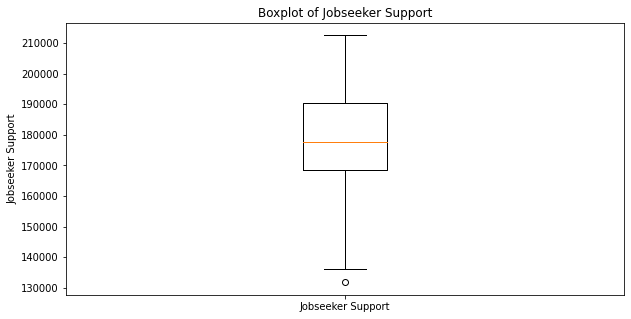

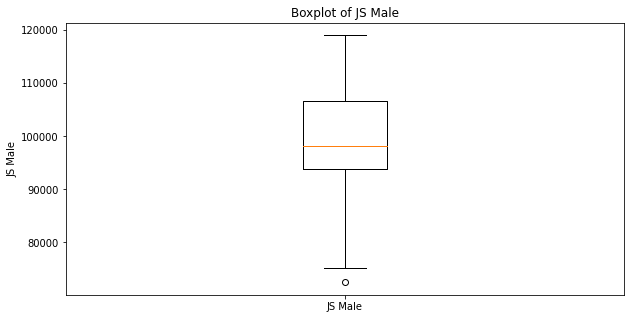

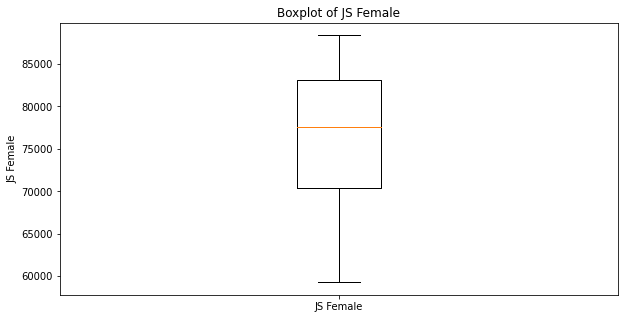

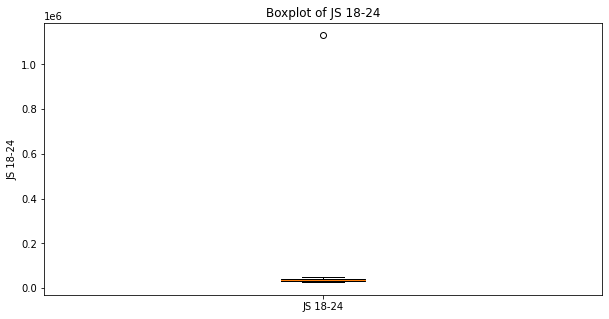

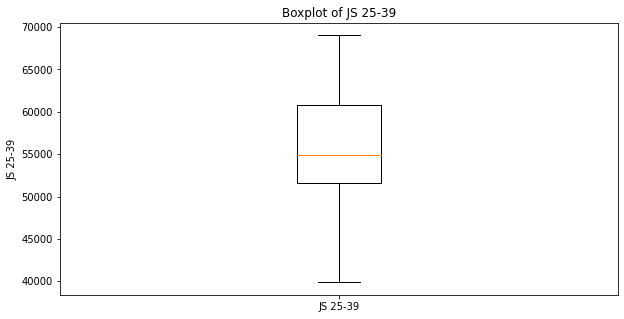

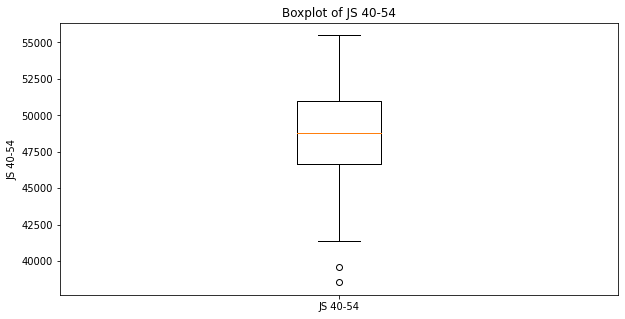

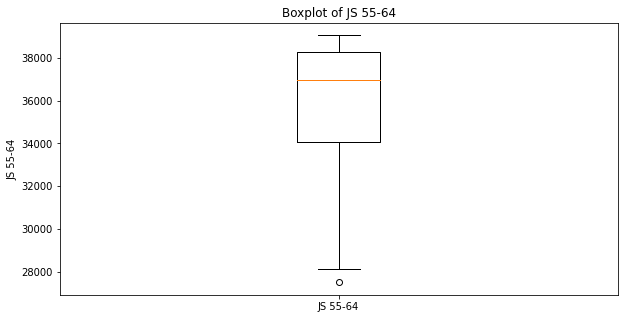

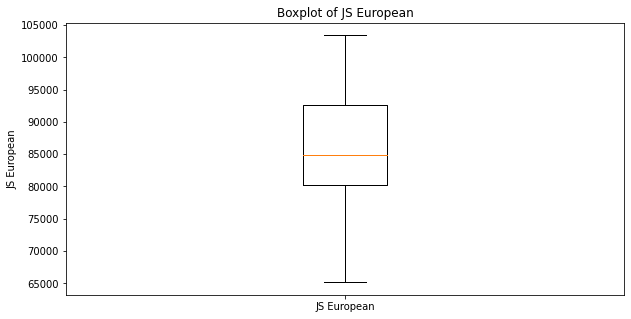

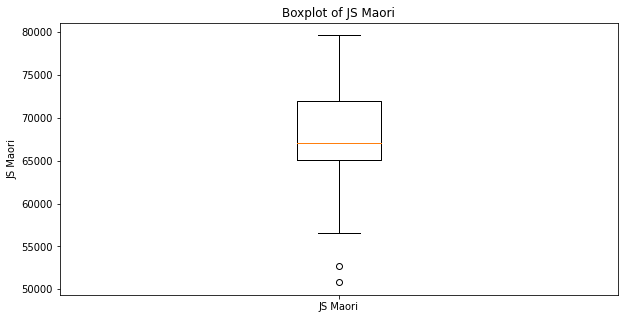

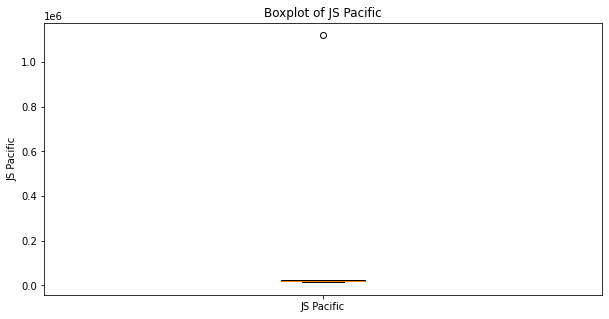

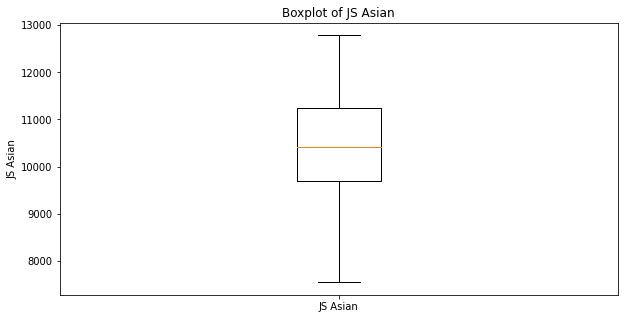

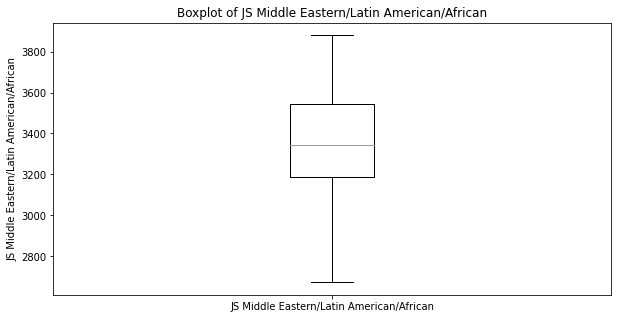

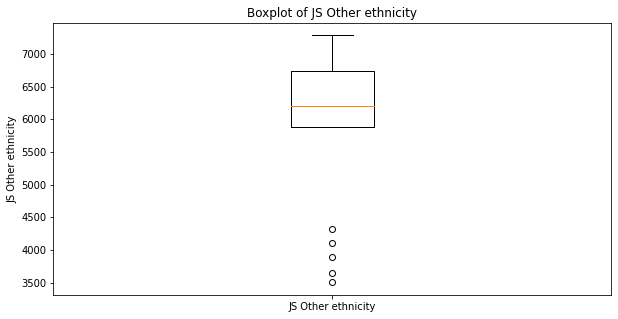

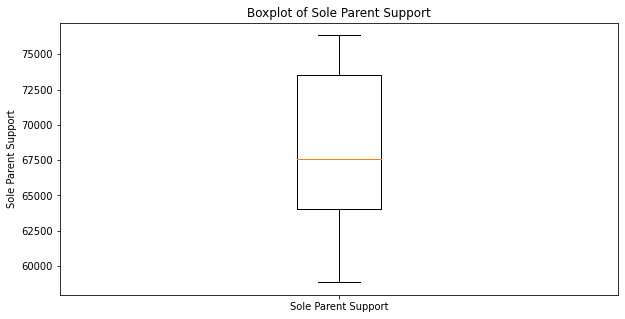

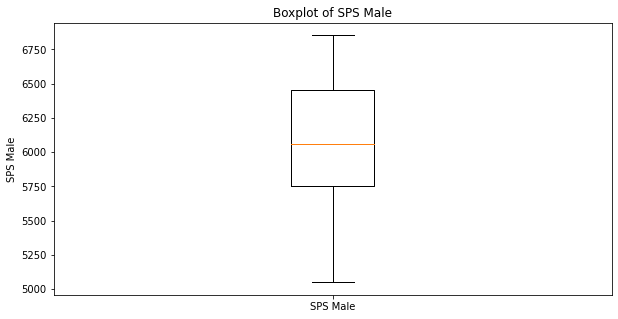

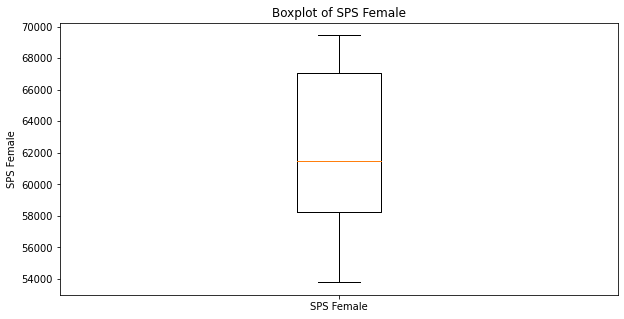

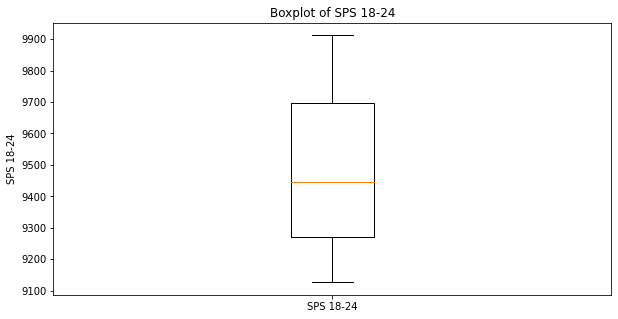

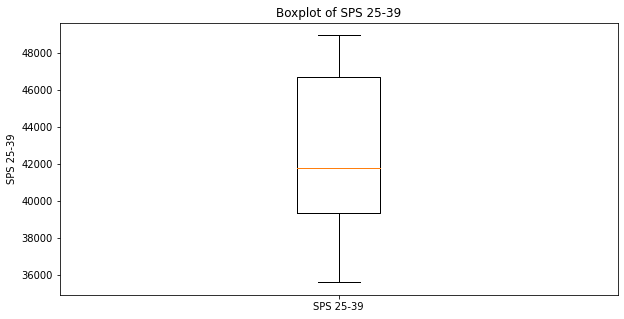

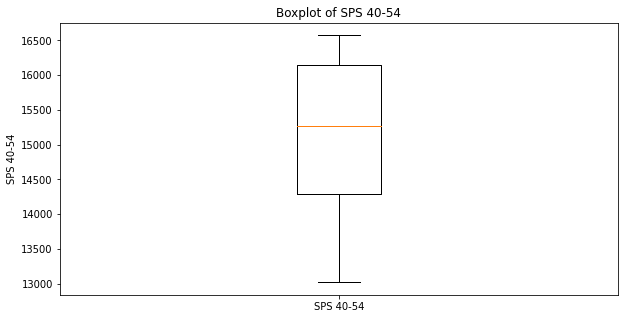

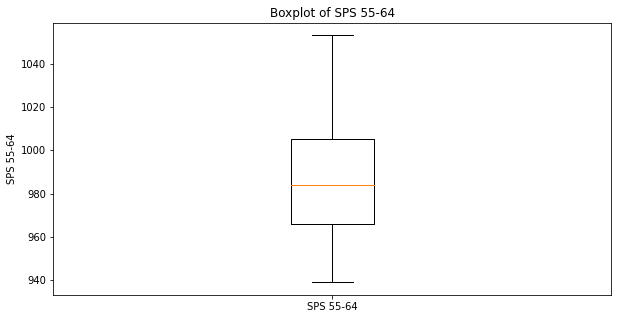

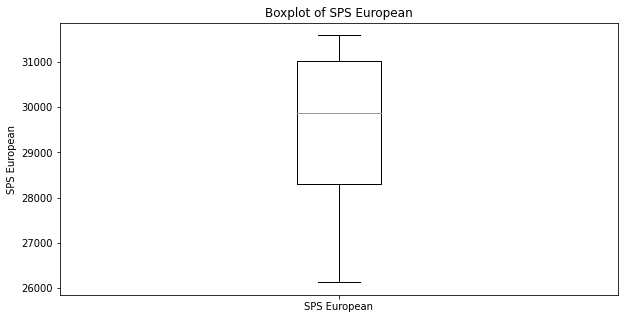

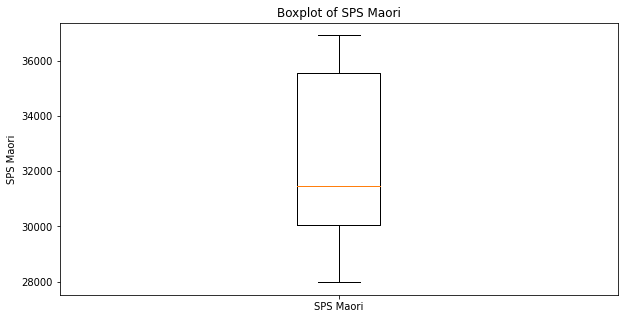

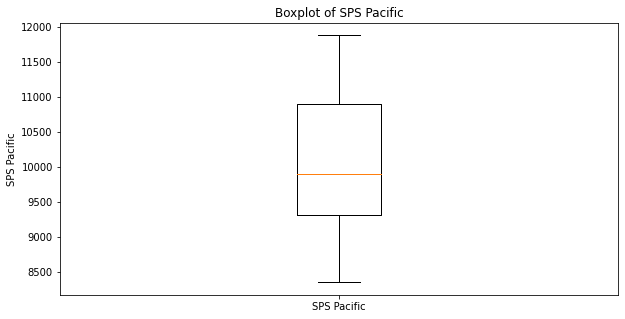

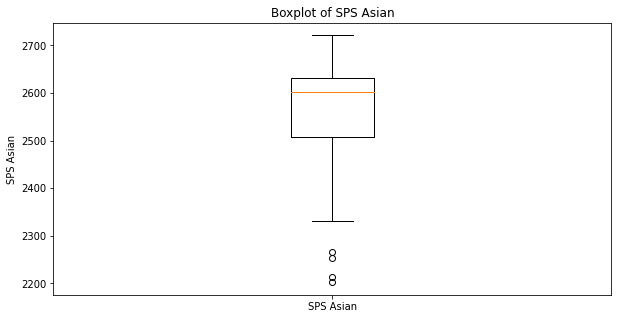

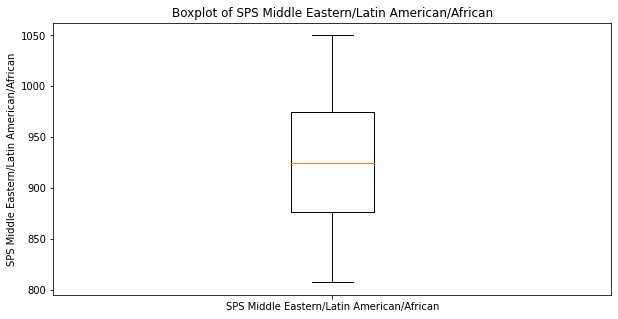

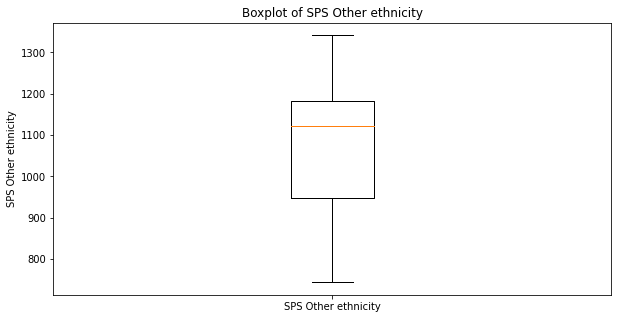

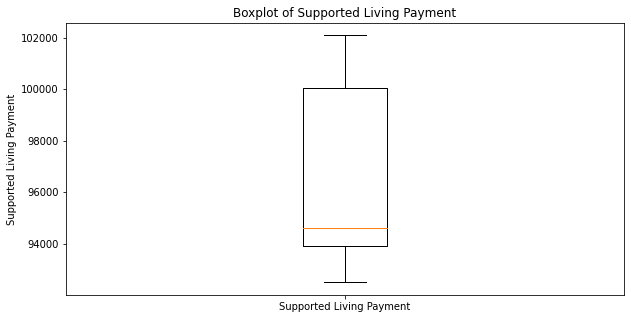

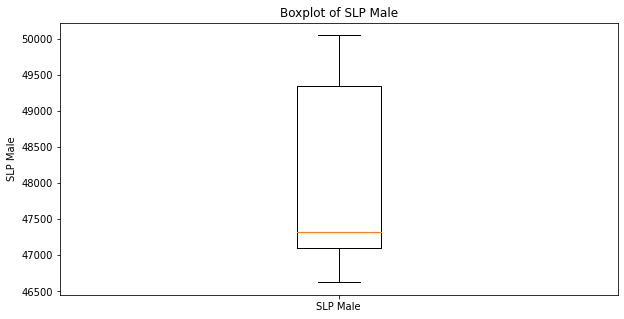

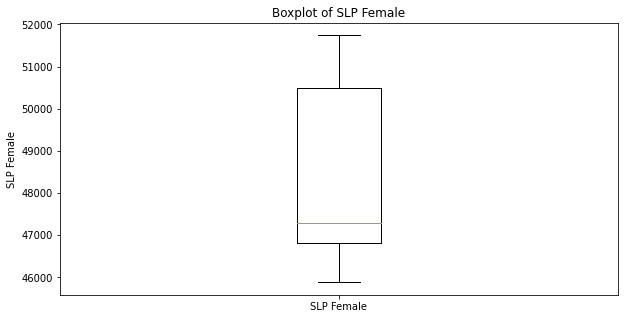

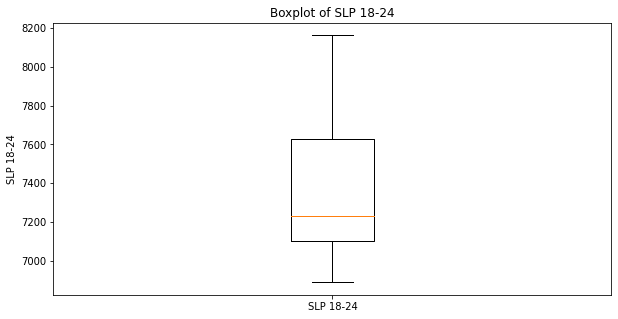

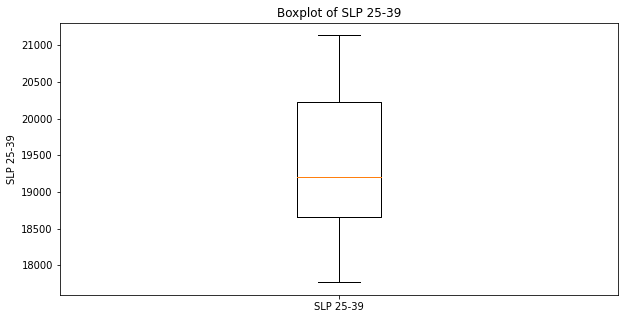

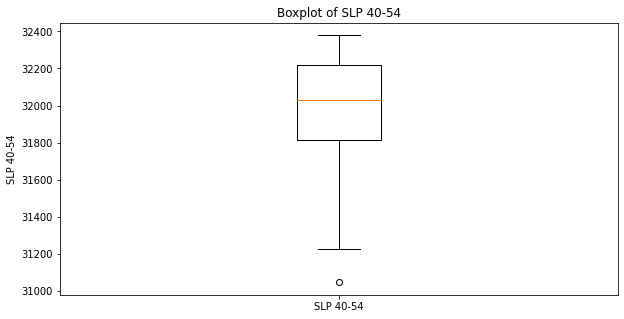

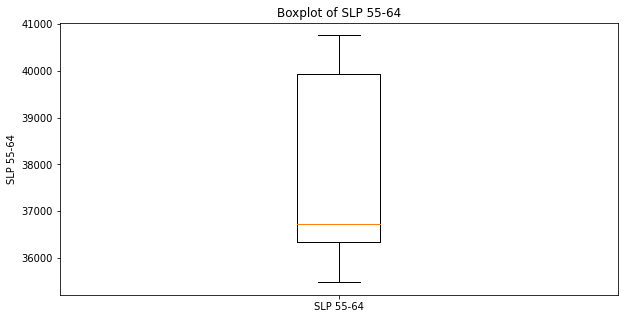

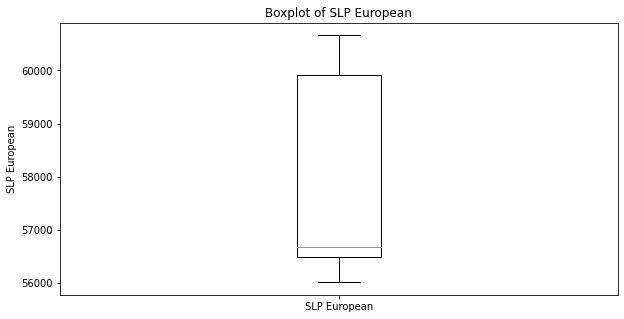

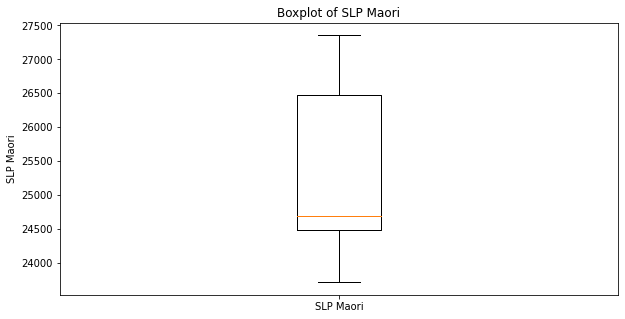

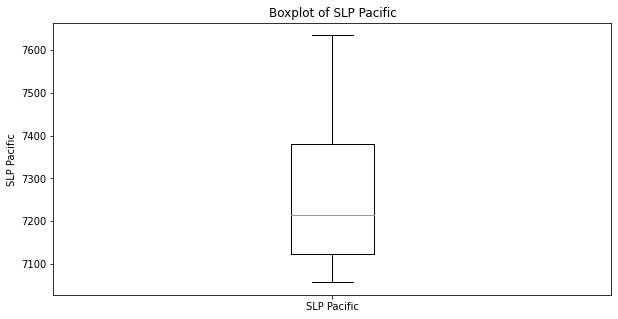

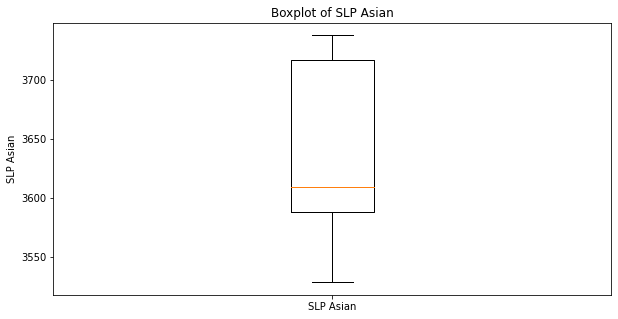

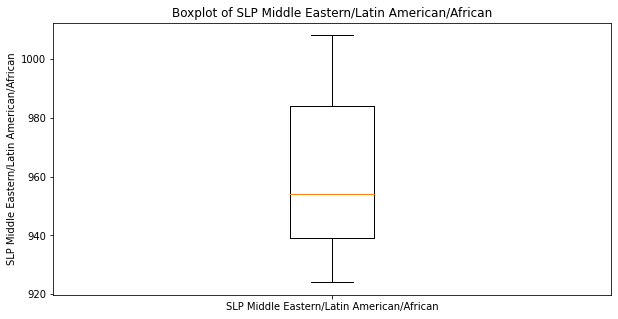

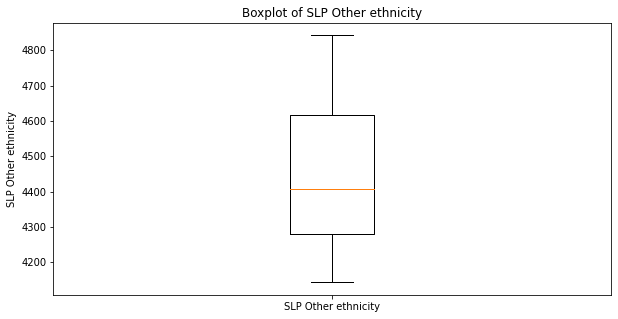

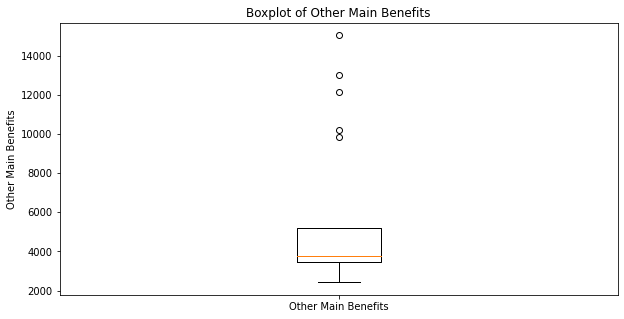

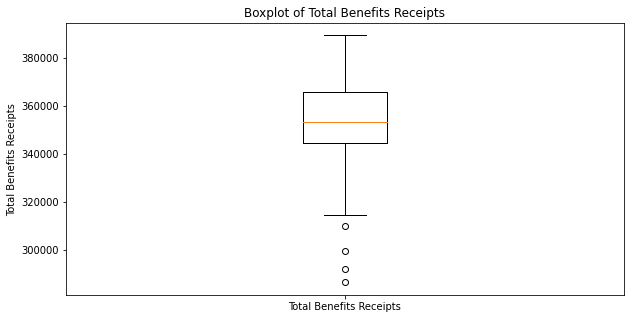

In [6]:
# Use boxplot to check the outliers
for column in columns_to_convert:
    data = msd.select(col(column).cast('int')).rdd.flatMap(lambda x: x).collect()
    
    data = [x for x in data if x is not None]
    
    
    plt.figure(figsize=(10, 5))
    plt.boxplot(data)
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.xticks([1], [column]) 
    plt.show()

In [7]:
# Fill the missing values with median value
for column in columns_to_convert:
    column_dtype = dict(msd.dtypes)[column]
    if column_dtype in ['int', 'double', 'float']:
        median_value = msd.approxQuantile(column, [0.5], 0.01)[0]
        msd = msd.fillna(median_value, subset=[column])

In [8]:
null_counts_dict = msd.select([sum(col(c).isNull().cast("int")).alias(c) for c in msd.columns]).collect()[0].asDict()

null_columns = {k: v for k, v in null_counts_dict.items() if v > 0}

if null_columns:
    for col_name, null_count in null_columns.items():
        print(f"Column '{col_name}' has {null_count} null values")
else:
    print("No columns have null values")

No columns have null values


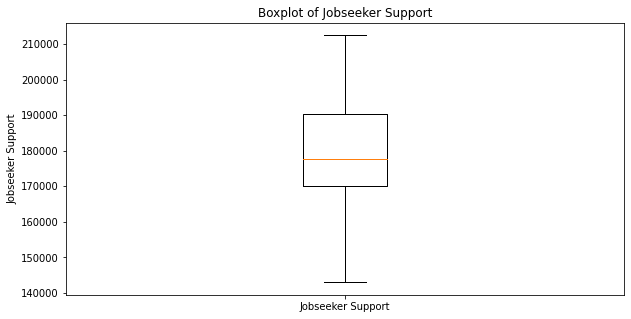

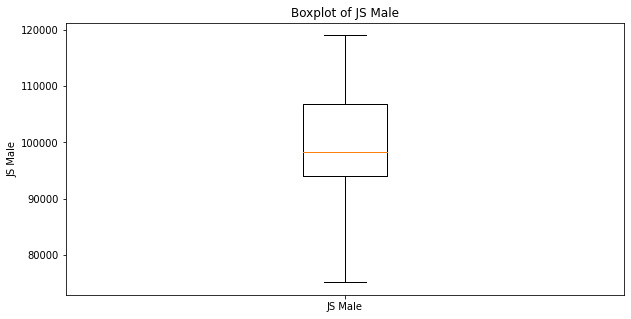

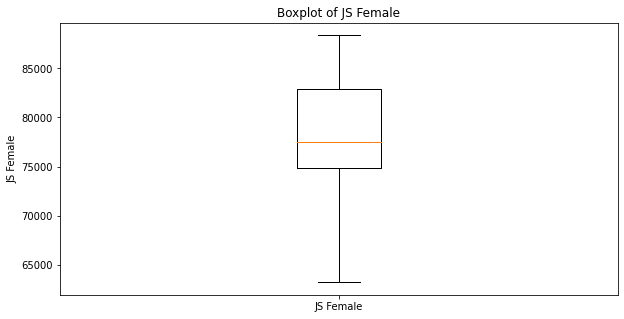

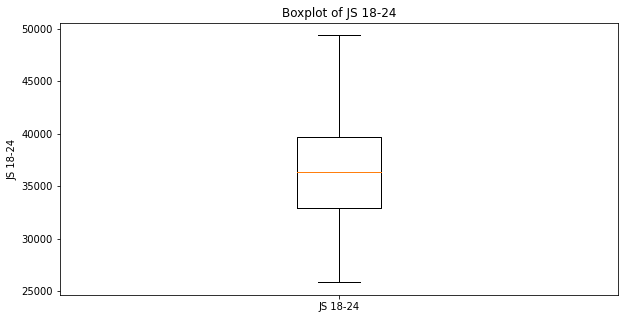

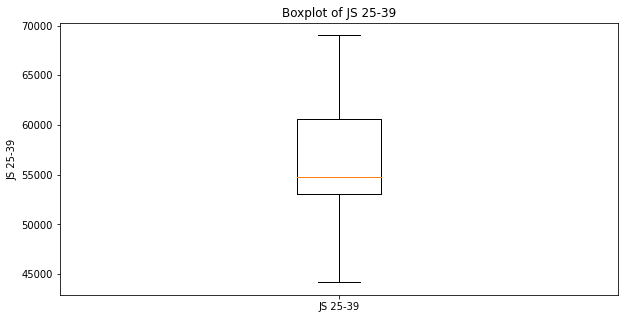

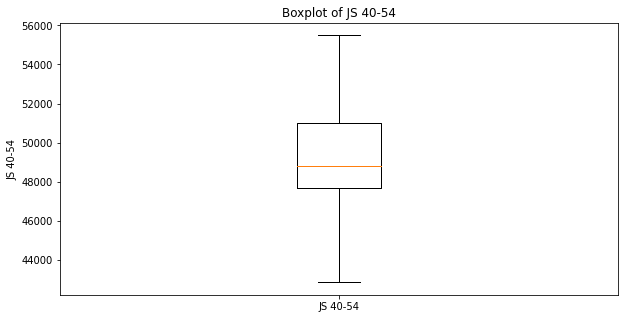

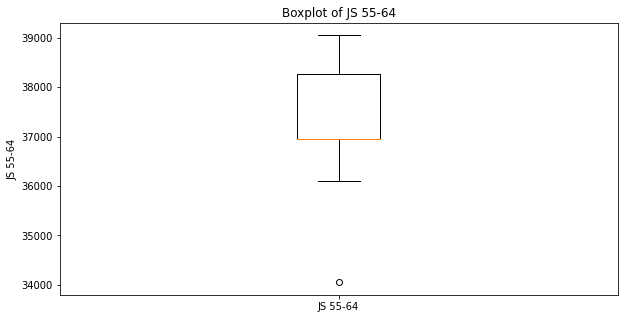

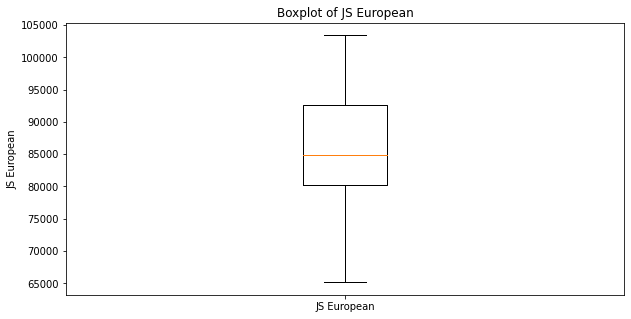

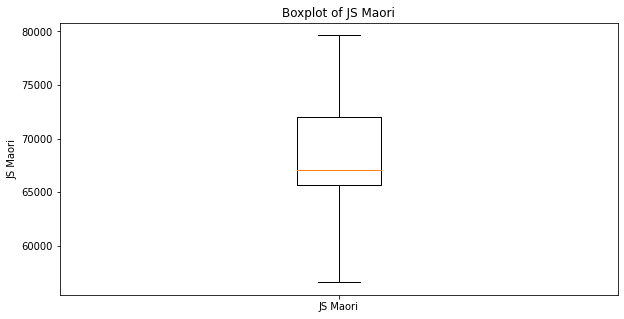

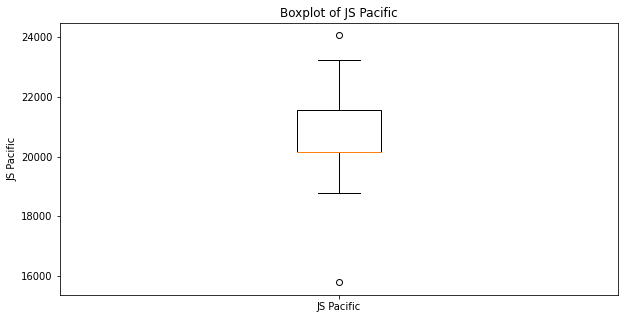

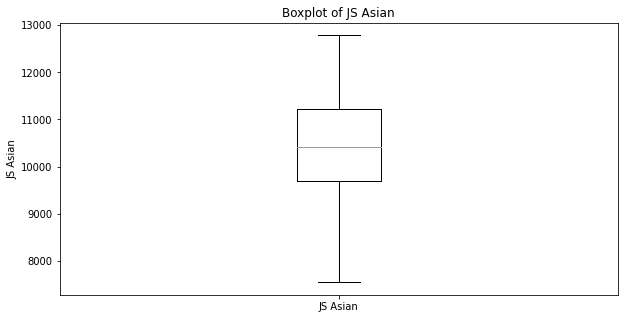

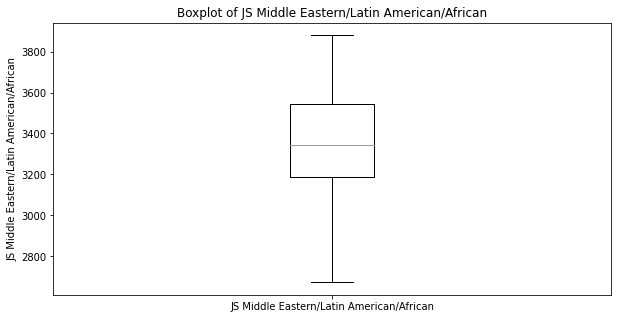

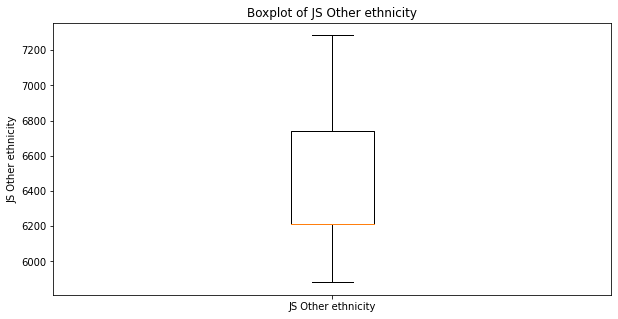

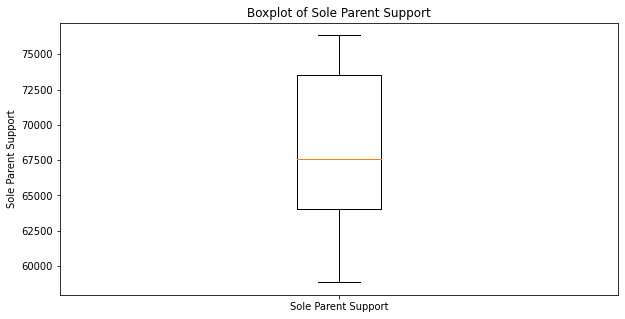

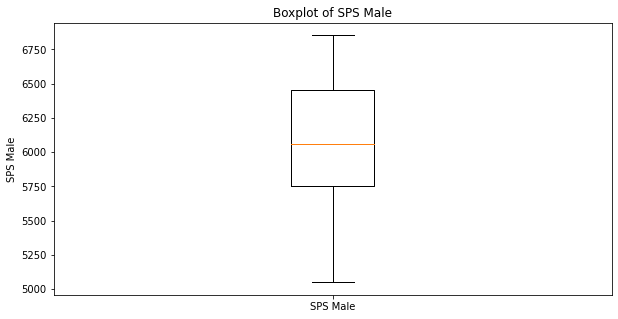

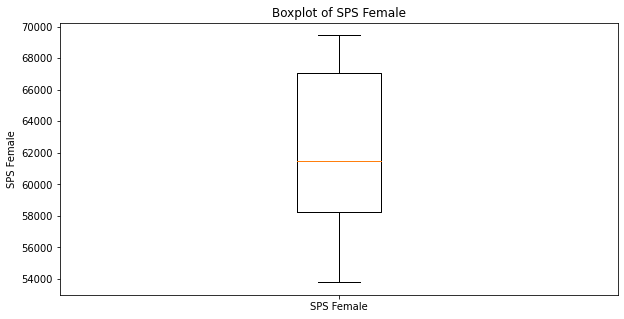

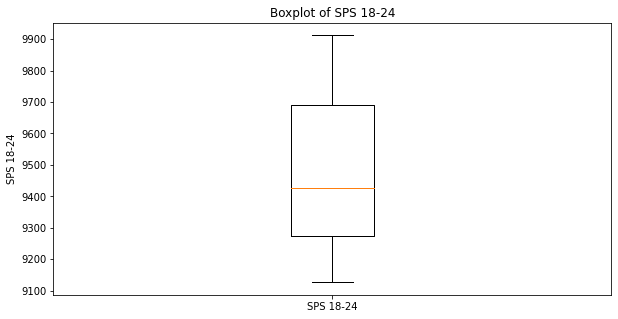

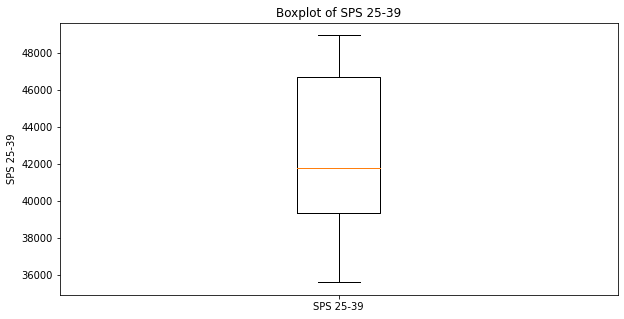

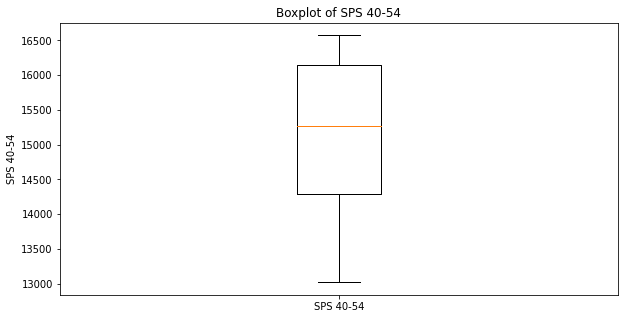

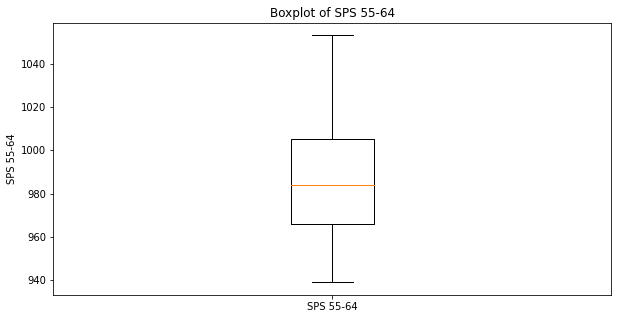

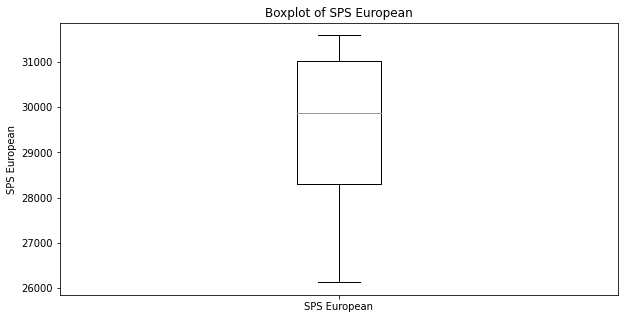

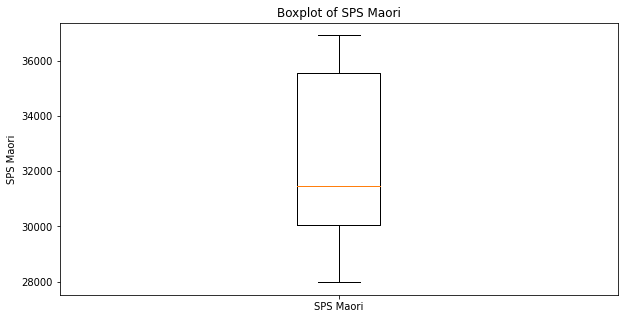

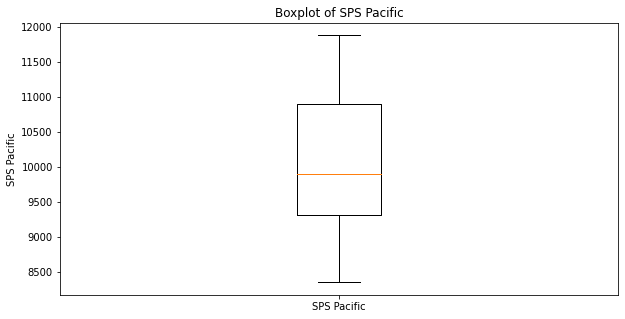

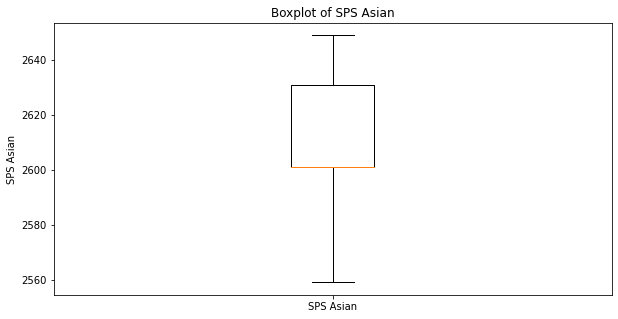

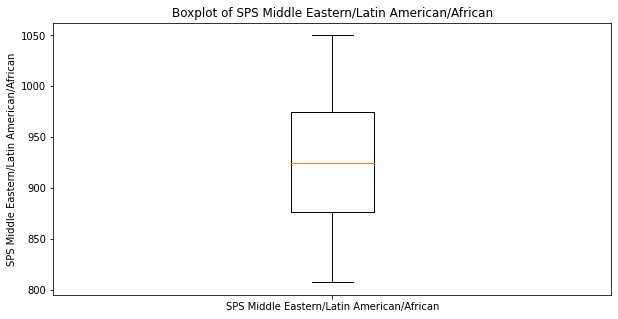

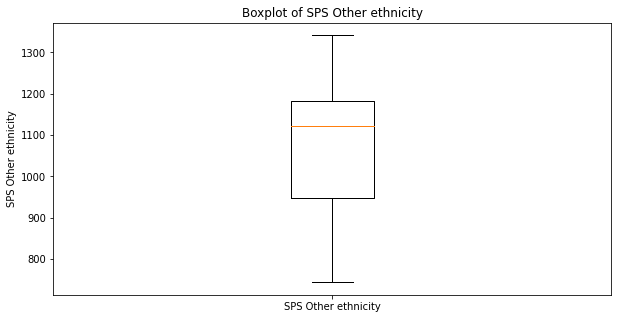

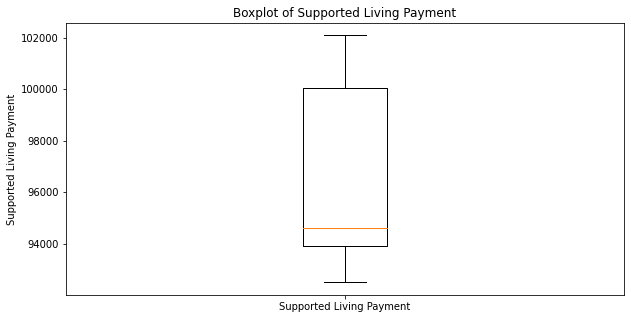

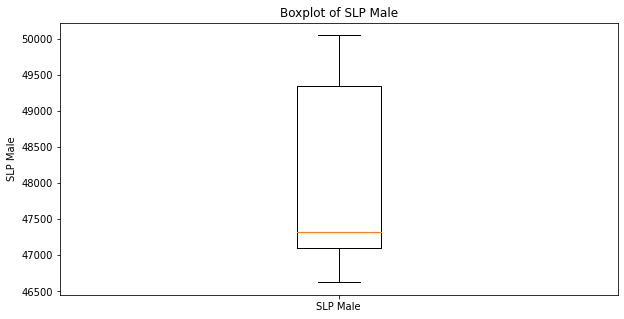

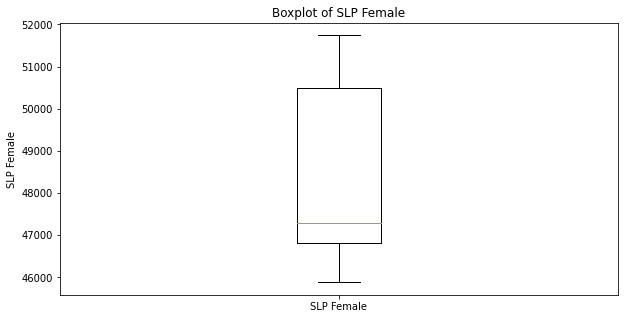

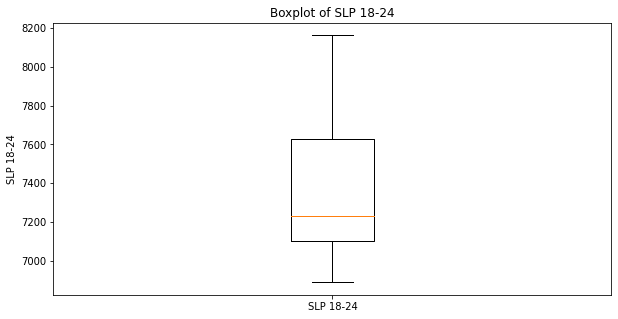

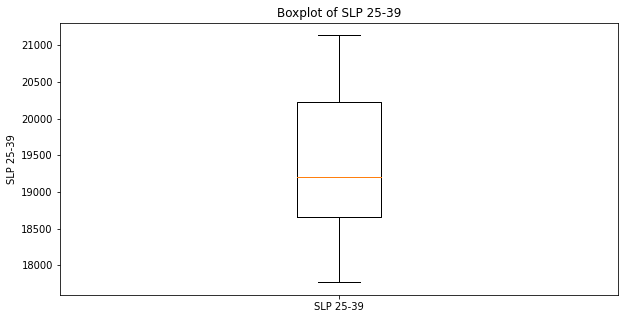

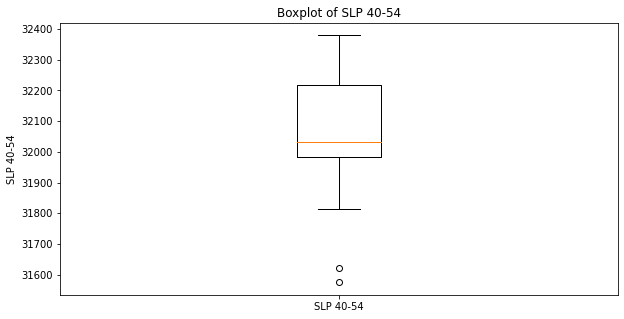

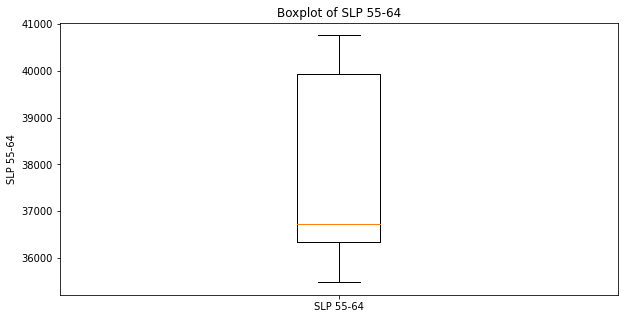

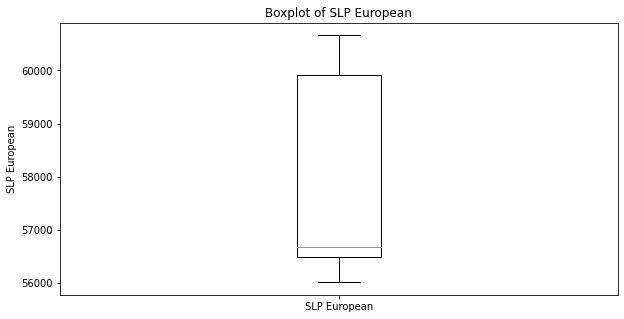

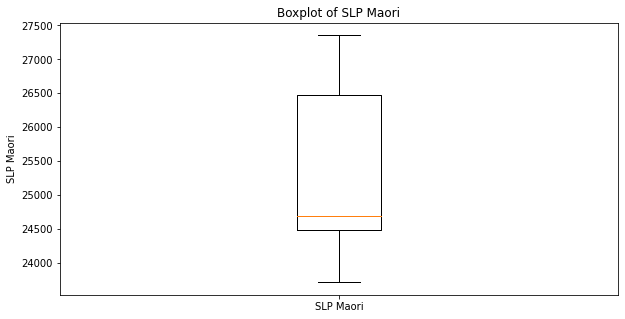

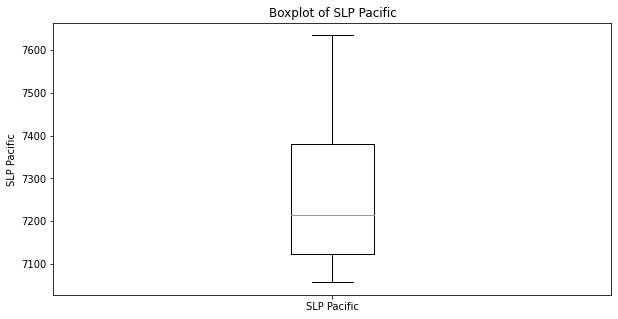

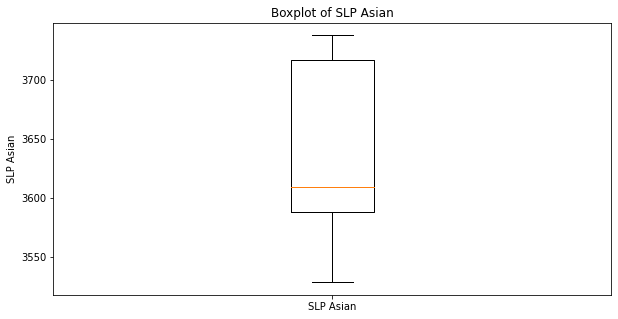

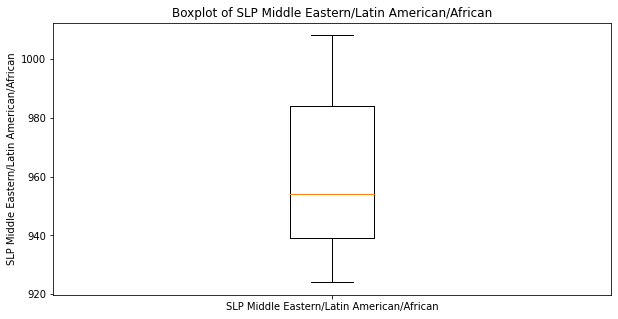

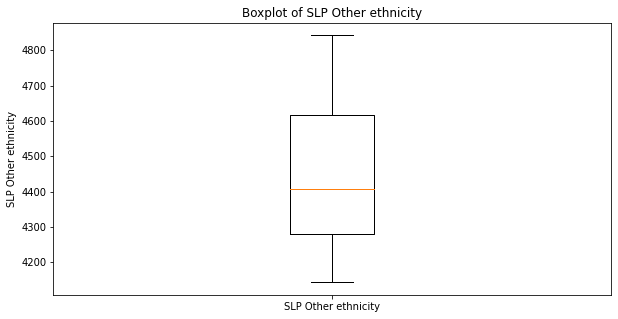

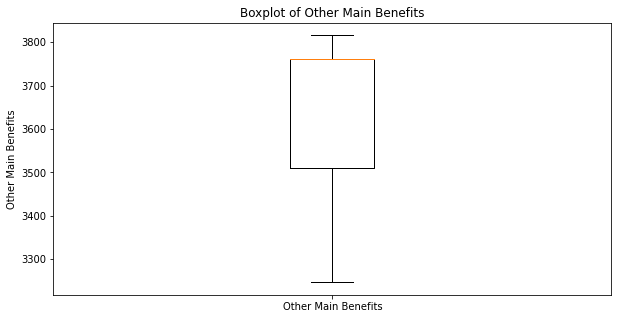

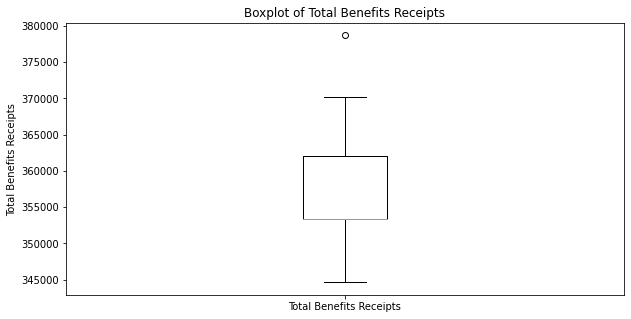

In [11]:
# Fill the outliers with median value
median_values = {}
for column in columns_to_convert:
    median_value = msd.approxQuantile(column, [0.5], 0.01)[0]
    median_values[column] = median_value

for column in columns_to_convert:
    column_dtype = dict(msd.dtypes)[column]
    if column_dtype in ['int', 'double', 'float']:
        Q1 = msd.approxQuantile(column, [0.25], 0.01)[0]
        Q3 = msd.approxQuantile(column, [0.75], 0.01)[0]
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        msd = msd.withColumn(column, expr(f"""
            CASE
                WHEN `{column}` < {lower_bound} OR `{column}` > {upper_bound} THEN {median_values[column]}
                ELSE `{column}`
            END
        """))



for column in columns_to_convert:
    data = msd.select(col(column)).rdd.flatMap(lambda x: x).collect()
    data = [x for x in data if x is not None]
    
    if len(data) == 0:
        continue  
    
    plt.figure(figsize=(10, 5))
    plt.boxplot(data)
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.xticks([1], [column])  
    plt.show()


In [24]:
# Add new features
msd = msd.withColumn('JS_lowAge', col('JS 18-24') + col('JS 25-39'))
msd = msd.withColumn('JS_highAge', col('JS 40-54') + col('JS 55-64'))
msd = msd.withColumn('SPS_lowAge', col('SPS 18-24') + col('SPS 25-39'))
msd = msd.withColumn('SPS_highAge', col('SPS 40-54') + col('SPS 55-64'))
msd = msd.withColumn('SLP_lowAge', col('SLP 18-24') + col('SLP 25-39'))
msd = msd.withColumn('SLP_highAge', col('SLP 40-54') + col('SLP 55-64'))

In [25]:
# Data reduction
cols_to_drop = ['JS 18-24', 'JS 25-39', 'JS 40-54','JS 55-64', 'SPS 18-24', 'SPS 25-39', 'SPS 40-54', 'SPS 55-64', 'SLP 18-24', 'SLP 25-39', 'SLP 40-54','SLP 55-64',
                'JS Middle Eastern/Latin American/African', 'JS Other ethnicity','SPS Middle Eastern/Latin American/African', 'SPS Other ethnicity','SLP Middle Eastern/Latin American/African', 'SLP Other ethnicity',
                'Other Main Benefits']

msd = msd.drop(*cols_to_drop)

In [26]:
msd.columns

['Date',
 'Jobseeker Support',
 'JS Male',
 'JS Female',
 'JS European',
 'JS Maori',
 'JS Pacific',
 'JS Asian',
 'Sole Parent Support',
 'SPS Male',
 'SPS Female',
 'SPS European',
 'SPS Maori',
 'SPS Pacific',
 'SPS Asian',
 'Supported Living Payment',
 'SLP Male',
 'SLP Female',
 'SLP European',
 'SLP Maori',
 'SLP Pacific',
 'SLP Asian',
 'Total Benefits Receipts',
 'JS_lowAge',
 'JS_highAge',
 'SPS_lowAge',
 'SPS_highAge',
 'SLP_lowAge',
 'SLP_highAge']

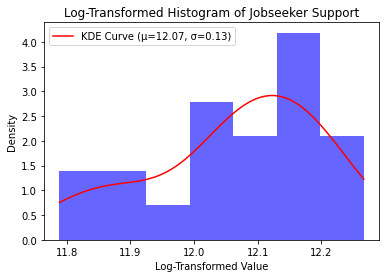

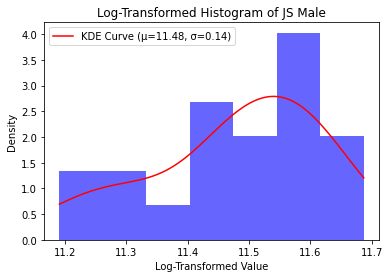

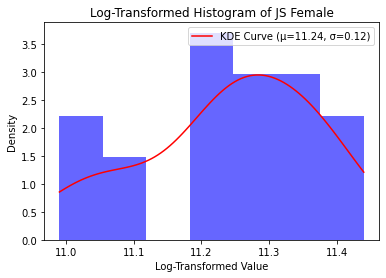

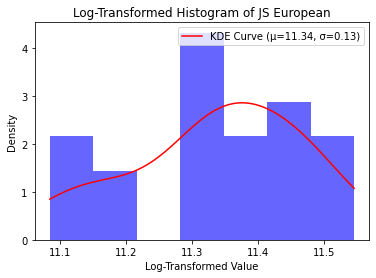

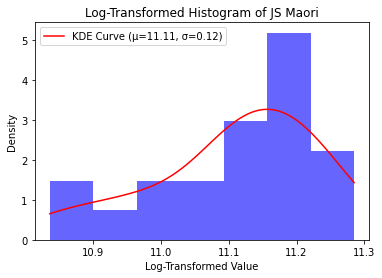

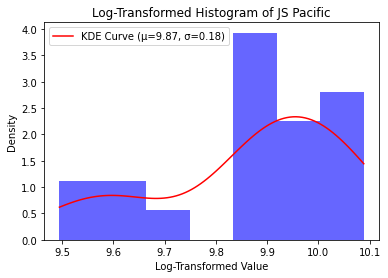

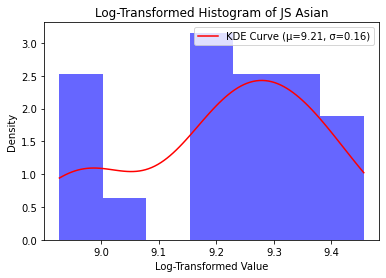

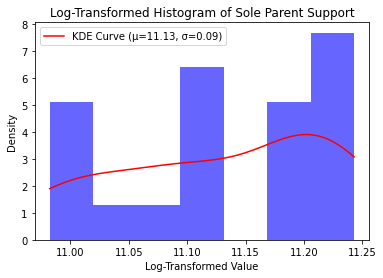

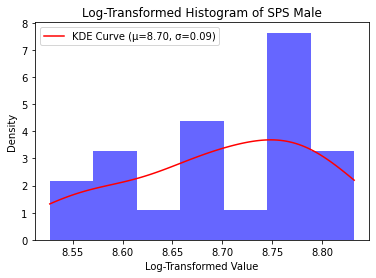

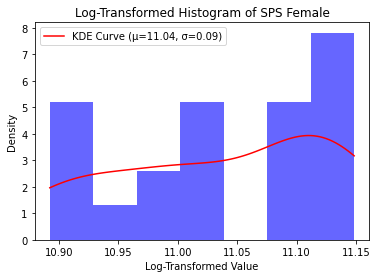

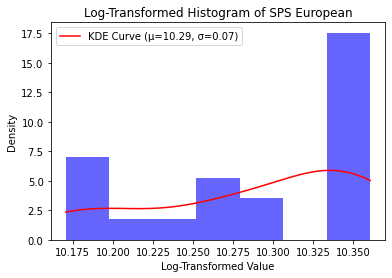

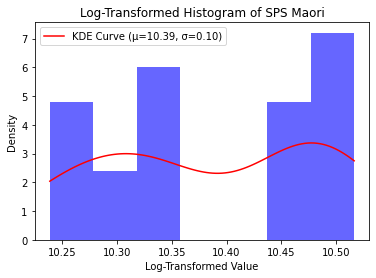

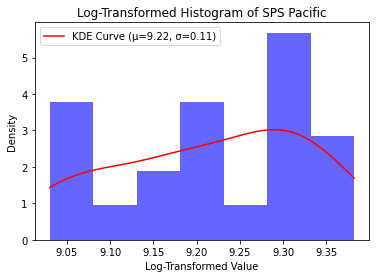

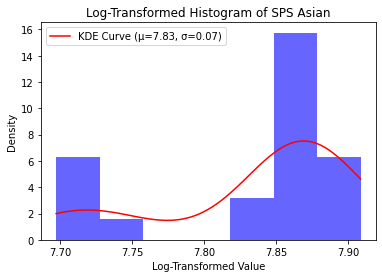

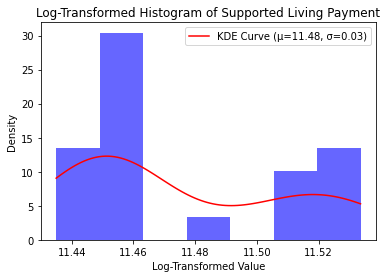

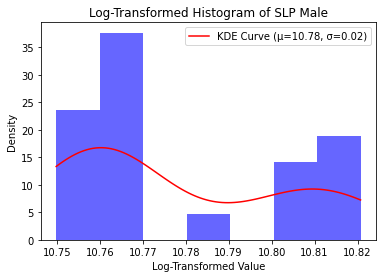

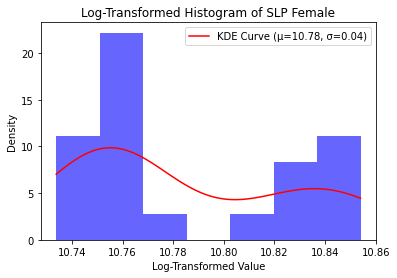

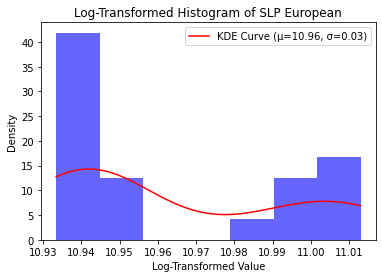

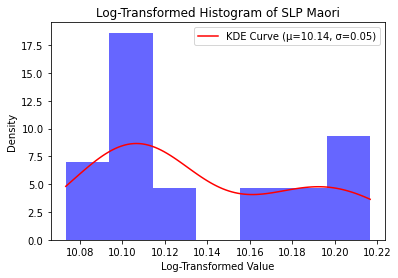

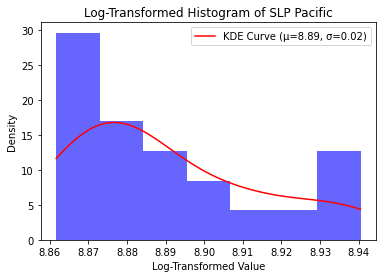

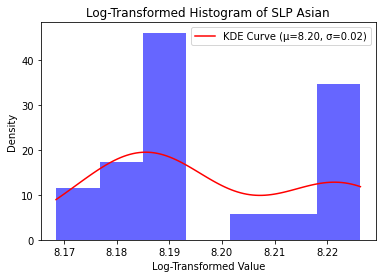

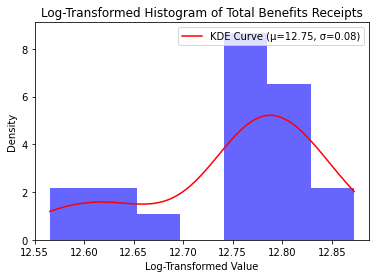

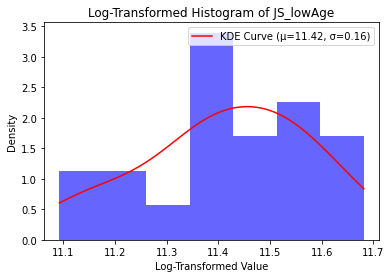

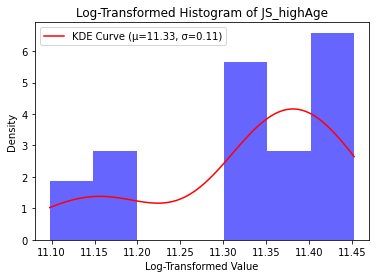

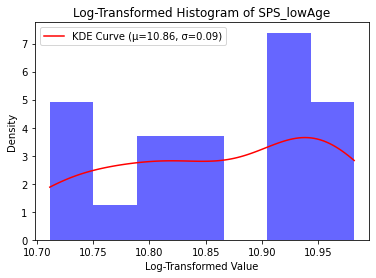

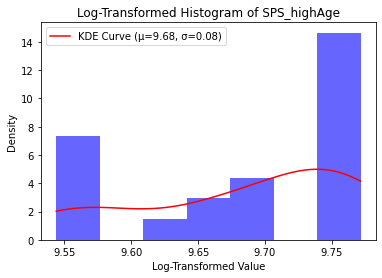

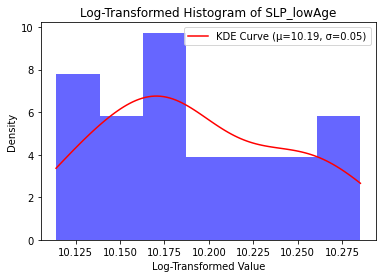

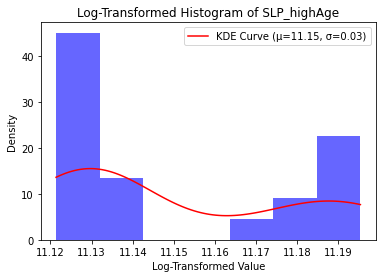

In [27]:
columns_to_convert = msd.columns[1:]
# Apply logarithmic transformation and generate hist chart
for column in columns_to_convert:
    msd = msd.withColumn(column, when(col(f'`{column}`') > 0, log(col(f'`{column}`'))).otherwise(None))

for column in columns_to_convert:
    data = msd.select(col(f'`{column}`')).rdd.flatMap(lambda x: x).collect()
    
    data = [x for x in data if x is not None]
    
    if len(data) == 0:
        continue  
    data_to_plot = np.array(data)
    mu, sigma = data_to_plot.mean(), data_to_plot.std()
    kde = gaussian_kde(data_to_plot)
    x = np.linspace(data_to_plot.min(), data_to_plot.max(), 100)
    y = kde.evaluate(x)
    
    plt.figure(figsize=(6, 4))
    plt.hist(data_to_plot, bins=7, alpha=0.6, density=True, color='blue')
    plt.plot(x, y, 'r-', label=f'KDE Curve (μ={mu:.2f}, σ={sigma:.2f})')
    plt.title(f'Log-Transformed Histogram of {column}')
    plt.xlabel('Log-Transformed Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

24/05/24 10:59:15 WARN Instrumentation: [a84219a2] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[11.8221219340987...| 12.58440291123102|12.587331206758579|
|[11.9299435793569...|12.644304995561221|  12.6514729337309|
+--------------------+------------------+------------------+

Coefficients: [0.5202115762707279,0.22467315249315872,0.15014234508601804]
Intercept: 2.2507816455601577
RMSE: 0.010634245508659235
R2: 0.9799301105646427


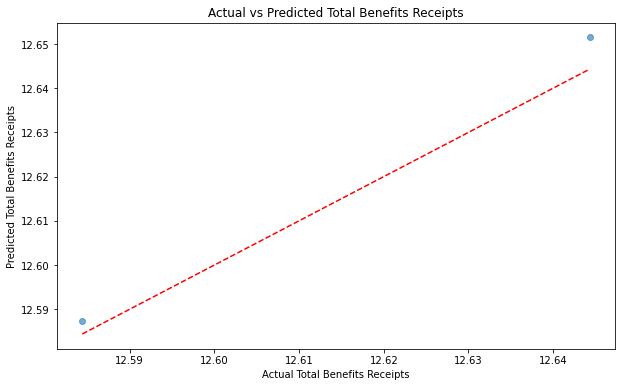

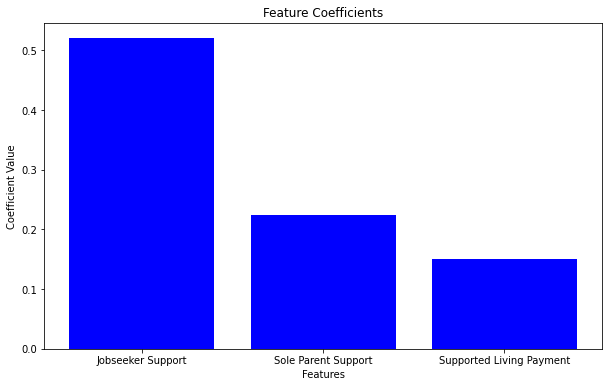

In [40]:
# Select features, build linear model and visualization
feature_columns = ['Jobseeker Support', 'Sole Parent Support', 'Supported Living Payment']
label_column = 'Total Benefits Receipts'

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
msd_features = assembler.transform(msd)

msd_features = msd_features.select('features', col(label_column).alias('label'))

lr = LinearRegression(featuresCol='features', labelCol='label', predictionCol='prediction')

train_data, test_data = msd_features.randomSplit([0.8, 0.2], seed=1234)

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select('features', 'label', 'prediction').show()

print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"R2: {training_summary.r2}")

predictions_pd = predictions.select('label', 'prediction').toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'], alpha=0.6)
plt.xlabel('Actual Total Benefits Receipts')
plt.ylabel('Predicted Total Benefits Receipts')
plt.title('Actual vs Predicted Total Benefits Receipts')
plt.plot([predictions_pd['label'].min(), predictions_pd['label'].max()],
         [predictions_pd['label'].min(), predictions_pd['label'].max()],
         color='red', linestyle='--')
plt.show()

coefficients = lr_model.coefficients.toArray()
feature_names = feature_columns
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients, color='blue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.show()

24/05/24 11:03:02 WARN Instrumentation: [2de204eb] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[10.7199358494363...|10.989723570136182|10.989814062300384|
|[10.7531896632529...|11.021706370843155|11.021801905161123|
+--------------------+------------------+------------------+

Coefficients: [0.7654079551332512,0.23455564147328298]
Intercept: 0.5451632186612089
RMSE: 4.3595938506670373e-05
R2: 0.9999997136216081


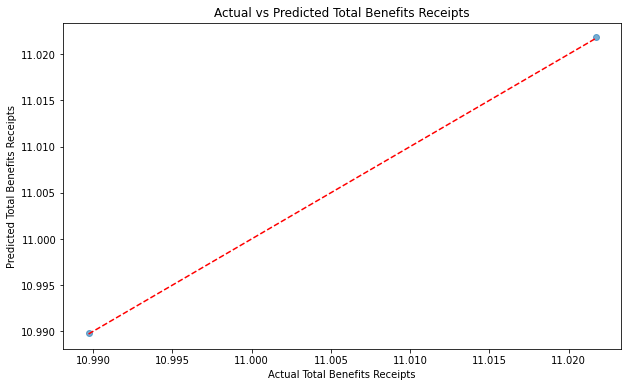

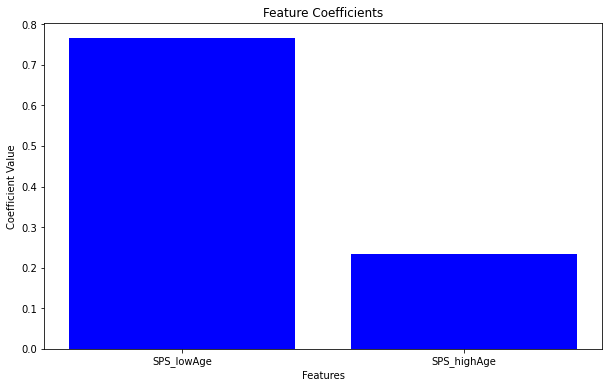

In [41]:
feature_columns = ['SPS_lowAge', 'SPS_highAge']
label_column = 'Sole Parent Support'

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
msd_features = assembler.transform(msd)

msd_features = msd_features.select('features', col(label_column).alias('label'))

lr = LinearRegression(featuresCol='features', labelCol='label', predictionCol='prediction')

train_data, test_data = msd_features.randomSplit([0.8, 0.2], seed=1234)

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select('features', 'label', 'prediction').show()

print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"R2: {training_summary.r2}")

predictions_pd = predictions.select('label', 'prediction').toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'], alpha=0.6)
plt.xlabel('Actual Total Benefits Receipts')
plt.ylabel('Predicted Total Benefits Receipts')
plt.title('Actual vs Predicted Total Benefits Receipts')
plt.plot([predictions_pd['label'].min(), predictions_pd['label'].max()],
         [predictions_pd['label'].min(), predictions_pd['label'].max()],
         color='red', linestyle='--')
plt.show()

coefficients = lr_model.coefficients.toArray()
feature_names = feature_columns
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients, color='blue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.show()

24/05/24 11:03:44 WARN Instrumentation: [3d8a89fd] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[11.1139542259783...|11.822121934098785|11.821127669962566|
|[11.2123202472279...| 11.92994357935697| 11.92680067400881|
+--------------------+------------------+------------------+

Coefficients: [0.3312220378918728,0.44127712003719066,0.09724729483196029,0.13582145378179056]
Intercept: 1.1971212609050672
RMSE: 0.004071411572988355
R2: 0.9988560739385188


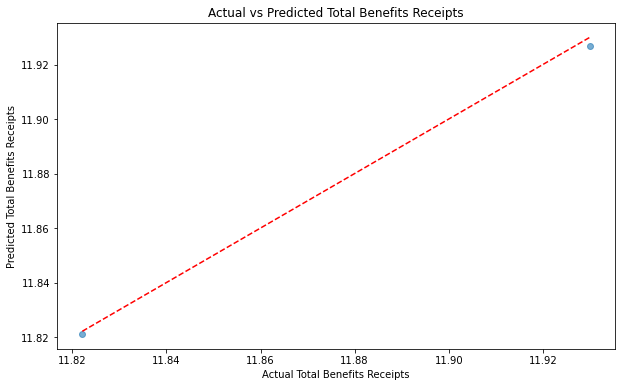

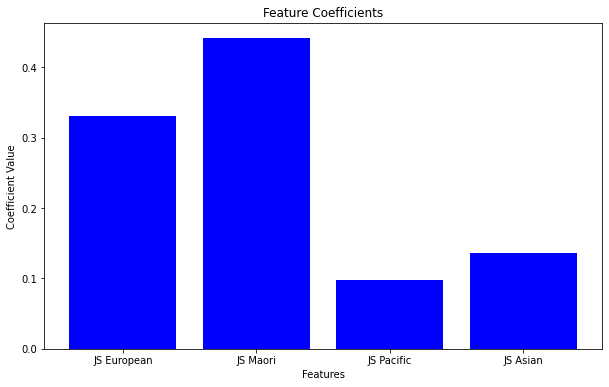

In [42]:
feature_columns = ['JS European', 'JS Maori','JS Pacific','JS Asian']
label_column = 'Jobseeker Support'

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
msd_features = assembler.transform(msd)

msd_features = msd_features.select('features', col(label_column).alias('label'))

lr = LinearRegression(featuresCol='features', labelCol='label', predictionCol='prediction')

train_data, test_data = msd_features.randomSplit([0.8, 0.2], seed=1234)

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select('features', 'label', 'prediction').show()

print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"R2: {training_summary.r2}")

predictions_pd = predictions.select('label', 'prediction').toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'], alpha=0.6)
plt.xlabel('Actual Total Benefits Receipts')
plt.ylabel('Predicted Total Benefits Receipts')
plt.title('Actual vs Predicted Total Benefits Receipts')
plt.plot([predictions_pd['label'].min(), predictions_pd['label'].max()],
         [predictions_pd['label'].min(), predictions_pd['label'].max()],
         color='red', linestyle='--')
plt.show()

coefficients = lr_model.coefficients.toArray()
feature_names = feature_columns
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients, color='blue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.show()

24/05/24 10:47:47 WARN Instrumentation: [02444bba] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[10.1735910227136...|10.989723570136182| 10.98813987959825|
|[10.2070306709189...|11.021706370843155|11.022902193712138|
+--------------------+------------------+------------------+

Coefficients: [0.36058009587885625,0.34717210606363086,0.2749959154806743,0.02527393974698408]
Intercept: 1.0814018654341835
RMSE: 0.0007531085656235937
R2: 0.9999145399076536


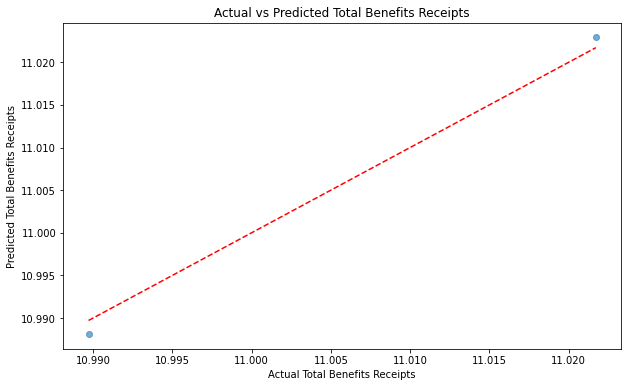

In [33]:
feature_columns = ['SPS European', 'SPS Maori','SPS Pacific','SPS Asian']
label_column = 'Sole Parent Support'

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
msd_features = assembler.transform(msd)

msd_features = msd_features.select('features', col(label_column).alias('label'))

lr = LinearRegression(featuresCol='features', labelCol='label', predictionCol='prediction')

train_data, test_data = msd_features.randomSplit([0.8, 0.2], seed=1234)

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select('features', 'label', 'prediction').show()

print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"R2: {training_summary.r2}")

predictions_pd = predictions.select('label', 'prediction').toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'], alpha=0.6)
plt.xlabel('Actual Total Benefits Receipts')
plt.ylabel('Predicted Total Benefits Receipts')
plt.title('Actual vs Predicted Total Benefits Receipts')
plt.plot([predictions_pd['label'].min(), predictions_pd['label'].max()],
         [predictions_pd['label'].min(), predictions_pd['label'].max()],
         color='red', linestyle='--')
plt.show()

24/05/24 10:48:57 WARN Instrumentation: [03759078] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[10.9353188075138...|11.438805185048459|11.439045020774477|
|[10.9408625317330...|11.446721557846924|  11.4490175768007|
+--------------------+------------------+------------------+

Coefficients: [0.5567393330015734,0.35401975277854214,0.04766055320003879,-0.015911610669619373]
Intercept: 1.489354036658794
RMSE: 0.0005914079404492391
R2: 0.9996900314787355


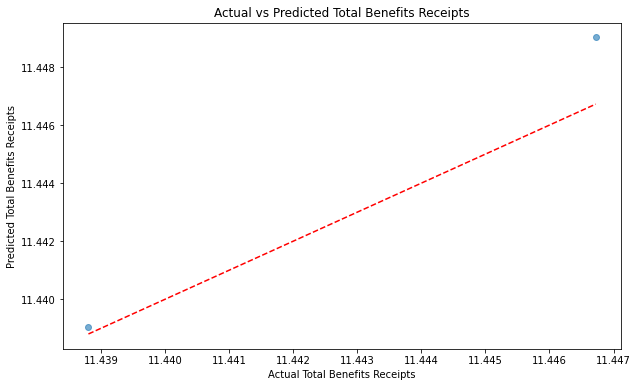

In [34]:
feature_columns = ['SLP European', 'SLP Maori','SLP Pacific','SLP Asian']
label_column = 'Supported Living Payment'

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
msd_features = assembler.transform(msd)

msd_features = msd_features.select('features', col(label_column).alias('label'))

lr = LinearRegression(featuresCol='features', labelCol='label', predictionCol='prediction')

train_data, test_data = msd_features.randomSplit([0.8, 0.2], seed=1234)

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select('features', 'label', 'prediction').show()

print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"R2: {training_summary.r2}")

predictions_pd = predictions.select('label', 'prediction').toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'], alpha=0.6)
plt.xlabel('Actual Total Benefits Receipts')
plt.ylabel('Predicted Total Benefits Receipts')
plt.title('Actual vs Predicted Total Benefits Receipts')
plt.plot([predictions_pd['label'].min(), predictions_pd['label'].max()],
         [predictions_pd['label'].min(), predictions_pd['label'].max()],
         color='red', linestyle='--')
plt.show()